### Oscillator-Qubit Architecture

As with the displacement gate, the beamsplitter operator is generally part of the native gate set, allowing direct implementation. Here, we implement it in Bosonic Qiskit under photon loss and evaluate the fidelity relative to the "ideal  state." Specifically, we consider a beamsplitter between two modes in the state $|1\rangle$ with $\theta = \phi = 1$, as we did with the qubit-only case.

In [7]:
import sys
import os

# Adjust the path based on your directory structure
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Now you can import c2qa and other modules from bosonic-qiskit
import c2qa
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit_aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector

In [8]:
def simulate_mode_beamsplitter(theta=1, noise=True, photon_loss_rate=0.0001, gate_time=100, shots=100):
    """
    Simulates a two-modebeamsplitter gate.

    Args:
        theta (float): Beamsplitter parameter (mixing angle).
        noise (bool): Whether to include photon loss noise in the simulation.
        photon_loss_rate (float): Photon loss rate in units of 1/ns (only relevant if noise=True).
        gate_time (int): Duration of the beamsplitter gate in nanoseconds (only relevant if noise=True).
        shots (int): Number of shots for the simulation (only relevant if noise=True).
        
    Returns:
        Statevector: If noise=True, returns a tuple of statevectors. If noise=False, returns the statevector.
    """
    # Define the number of qumodes and qubits per qumode
    num_qumodes = 2
    num_qubits_per_qumode = 2  # Cutoff = 2^4 = 16
    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    
    # Create the circuit
    cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode) if noise else None
    circuit = c2qa.CVCircuit(qmr, cr) if noise else c2qa.CVCircuit(qmr)
    
    # Initialize the two qumodes in Fock state |1>
    circuit.cv_initialize(1, qmr[0])
    circuit.cv_initialize(1, qmr[1])

    # Apply a beamsplitter gate with the specified mixing angle (theta)
    circuit.cv_bs(theta, qmr[0], qmr[1], duration=gate_time if noise else None, unit="ns" if noise else None)
    
    if noise:
        # Add photon loss noise
        noise_pass = c2qa.kraus.PhotonLossNoisePass(
            photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="ns"
        )
        
        # Run the simulation with noise
        state, _, _ = c2qa.util.simulate(
            circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass
        )
        return state
    else:
        # Run the simulation without noise
        state, _, _ = c2qa.util.simulate(circuit)
        return state


# print(simulate_mode_beamsplitter(noise = True, shots=1024))

In [9]:
def compute_average_fidelity(theta, photon_loss_rate=0.0001, gate_time=100, shots=100):
    """
    Computes the average fidelity between the noiseless statevector and individual noisy statevectors,
    and includes the error from shot noise using numpy functions.
    
    Args:
        theta (float): Beamsplitter parameter (mixing angle).
        photon_loss_rate (float): Photon loss rate in units of 1/ns.
        gate_time (float): Gate time in ns.
        shots (int): Number of shots for the noisy simulation.
        
    Returns:
        tuple: The average fidelity and the standard error (shot noise error).
    """
    # Simulate the noiseless state
    state_no_noise = simulate_mode_beamsplitter(theta, noise=False)
    
    # Simulate the noisy statevectors
    noisy_statevectors = simulate_mode_beamsplitter(theta, noise=True, photon_loss_rate=photon_loss_rate, gate_time=gate_time, shots=shots)
    
    # Calculate fidelity for each noisy statevector
    fidelities = [state_fidelity(state_no_noise, noisy_state) for noisy_state in noisy_statevectors]
    
    # Compute the average fidelity using numpy
    average_fidelity = np.average(fidelities)
    
    # Calculate the standard error
    std_error = np.std(fidelities) / np.sqrt(shots)
    
    return average_fidelity, std_error

In [ ]:
## Suppress specific warnings
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", message="PhotonLossNoisePass ignores instructions without duration")
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

# Define parameters
photon_loss_rates = np.linspace(1e-4, 0.02, num=20)   # Photon loss from 10^-4 to 10^-2 (in 1/ns)
gate_times = [10, 100]  # Gate times in ns
theta = 1  # Fixed displacement value
shots = 1024

# Placeholder for results
results = {}

for gate_time in gate_times:
    # Initialize placeholders for fidelities and errors
    fidelities = []
    errors = []
    for photon_loss_rate in photon_loss_rates:
        average_fidelity, std_error = compute_average_fidelity(theta, photon_loss_rate, gate_time, shots)
        fidelities.append(average_fidelity)
        errors.append(std_error)
    
    # Store both fidelities and errors for the current gate time
    results[gate_time] = {
        'fidelities': fidelities,
        'errors': errors
    }

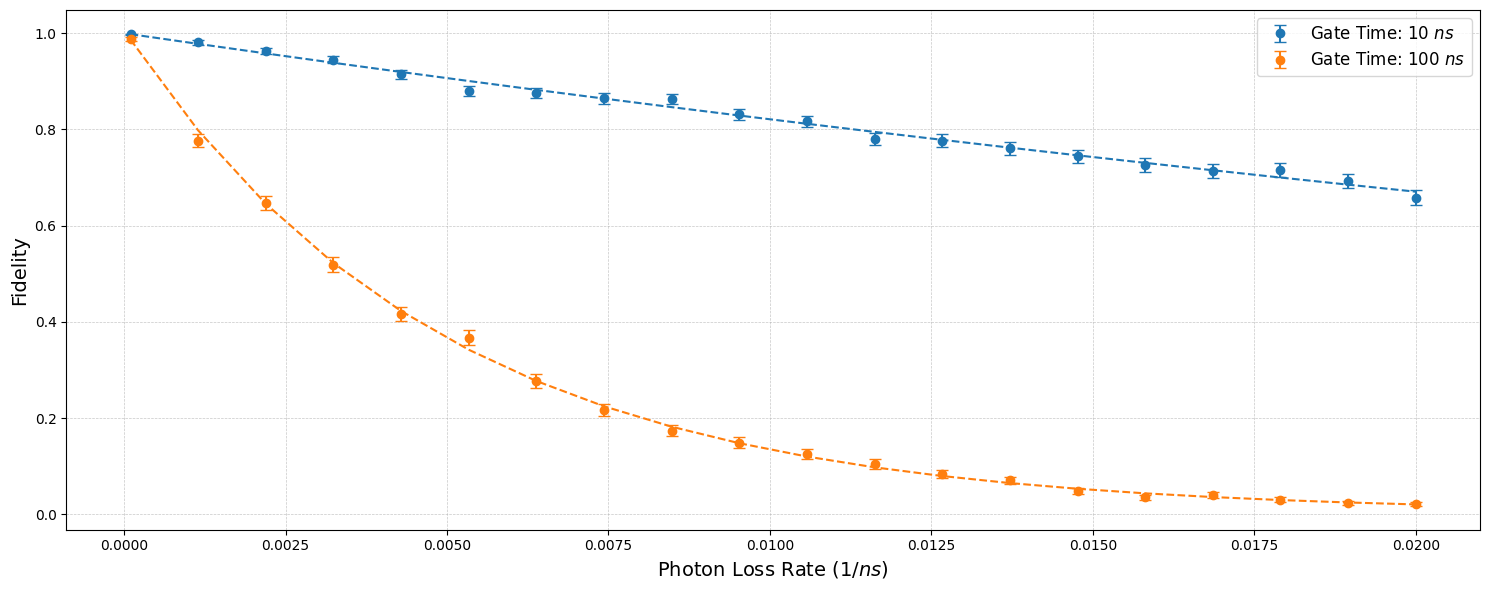

In [14]:
from scipy.optimize import curve_fit

# Define the exponential model
def exponential_model(x, a, b, c):
    return a * np.exp(-b * x) + c

# Initialize a dictionary to store fitted parameters
exponential_fits = {}

# Fit the exponential model for each gate time
for gate_time in gate_times:
    # Extract fidelities and errors for the current gate time
    fidelities = np.array(results[gate_time]['fidelities'])
    errors = np.array(results[gate_time]['errors'])
    
    # Perform the curve fitting
    popt, _ = curve_fit(
        exponential_model, photon_loss_rates, fidelities, sigma=errors, absolute_sigma=True
    )
    exponential_fits[gate_time] = popt


## Plotting
plt.figure(figsize=(15, 6))

# Loop over gate times to plot data and fits
for gate_time in gate_times:
    fidelities = np.array(results[gate_time]['fidelities'])
    errors = np.array(results[gate_time]['errors'])
    
    # Plot the original data with error bars
    data_points = plt.errorbar(
        photon_loss_rates,
        fidelities,
        yerr=errors,
        fmt='o',
        capsize=4,
        label=f'Gate Time: {gate_time} $ns$'
    )
    
    # Plot the exponential fit using the same color as the data points
    fit_params = exponential_fits[gate_time]
    predicted = exponential_model(photon_loss_rates, *fit_params)
    plt.plot(
        photon_loss_rates,
        predicted,
        linestyle='--', 
        color=data_points[0].get_color()
    )

plt.xlabel('Photon Loss Rate ($1/ns$)', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()


In [16]:
print("Fits:")
# Print the exponential coefficients for each gate time
for gate_time, params in exponential_fits.items():
    a, b, c = params
    print(f"Gate Time: {gate_time} ns -> Fidelity = {a:.4f}e^(-{b:.4f}x) + {c:.4f}")  # x is photon loss rate


Fits:
Gate Time: 10 ns -> Fidelity = 1.1266e^(-17.2832x) + -0.1270
Gate Time: 100 ns -> Fidelity = 1.0032e^(-203.5481x) + 0.0033
